## Рецепты и LDA

Датасет с ингредиентами, но без названий рецептов — достаточно нетривиально, но дает пространство для творчества.

In [1]:
import json
with open("_e3e6a884a5431c0a4f8f24f439410ce0_recipes.json") as f:
    recipes = json.load(f)

In [4]:
print(recipes[0:2])

[{'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}, {'id': 25693, 'cuisine': 'southern_us', 'ingredients': ['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'green tomatoes', 'yellow corn meal', 'milk', 'vegetable oil']}]


Оказывается, для каждого рецепта указана еще и кухня.

## Создание корпуса и LDA-модели

Предобработки как таковой не требуется. Составляем корпус:

In [5]:
from gensim import corpora, models
import numpy as np

/anaconda2/envs/python3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [6]:
!pip3 install paramiko

    100% |████████████████████████████████| 194kB 759kB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 628kB/s ta 0:00:011
    100% |████████████████████████████████| 61kB 597kB/s ta 0:00:011
    100% |████████████████████████████████| 286kB 1.8MB/s ta 0:00:01
You are using pip version 18.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
texts = [recipe["ingredients"] for recipe in recipes]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts] 

Обучим LDA-модель с 50 темами, чтобы объединить те слова, которые часто встречаются рядом в текстах.

In [22]:
np.random.seed(32562)
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=50, id2word=dictionary, passes=5)

In [23]:
topics = ldamodel.show_topics(num_topics=50, formatted=False)
ldamodel.show_topics(num_topics=50)

[(0,
  '0.155*"garlic powder" + 0.147*"paprika" + 0.113*"cayenne pepper" + 0.058*"onion powder" + 0.049*"salt" + 0.043*"ground black pepper" + 0.037*"black pepper" + 0.027*"chili powder" + 0.026*"apple cider vinegar" + 0.026*"dried oregano"'),
 (1,
  '0.095*"onions" + 0.092*"carrots" + 0.049*"salt" + 0.047*"bay leaf" + 0.043*"tomato paste" + 0.043*"bay leaves" + 0.041*"celery" + 0.039*"water" + 0.037*"celery ribs" + 0.036*"olive oil"'),
 (2,
  '0.181*"pepper" + 0.153*"salt" + 0.075*"eggs" + 0.065*"flour" + 0.056*"onions" + 0.043*"butter" + 0.027*"milk" + 0.027*"chicken" + 0.026*"garlic" + 0.025*"oil"'),
 (3,
  '0.101*"soy sauce" + 0.057*"sesame oil" + 0.048*"corn starch" + 0.046*"garlic" + 0.043*"green onions" + 0.039*"sugar" + 0.034*"water" + 0.030*"scallions" + 0.030*"salt" + 0.029*"ginger"'),
 (4,
  '0.119*"white vinegar" + 0.108*"cold water" + 0.093*"sauce" + 0.071*"chopped garlic" + 0.051*"dry sherry" + 0.037*"french bread" + 0.034*"boneless chicken breast" + 0.027*"caster sugar" 

Полученные результаты не лишены смысла — например, чаще остальных встречаются соль, сахар и различные виды масла; логично предположить, что они используются в приготовлении многих блюд. Также видно, что овощи группируются с овощами — тоже логично, например, для рецептов салатов.

Но при этом есть и ошибки — например, некий half & half, который каким-то образом попал в корпус, видимо, потому что объемы ингредиентов указали прописью. Последние из тем вышли какими-то немного странными — слишком много специй, которые не то что бы хорошо сочетаются вместе.

## Фильтрация словаря, создание второй модели и подсчет когерентности

Пофильтруем словарь по частоте, убирая самые часто встречающиеся слова, чтобы в темах не было слишком много соли, воды и прочего подобного.

In [24]:
import copy
dictionary2 = copy.deepcopy(dictionary)

In [25]:
dictsize_bfr = len(dictionary.dfs)
[dictionary2.dfs[key] for key in dictionary2.dfs.keys() if dictionary2.dfs[key] > 4000]
bad_ids = [key for key in dictionary2.dfs.keys() if dictionary2.dfs[key] > 4000]
dictionary2.filter_tokens(bad_ids)
dictsize_after = len(dictionary2.dfs)
print(dictsize_bfr)
dictsize_after

6714


6702

In [26]:
corpus2 = [dictionary2.doc2bow(text) for text in texts]
corpsize_bfr = 0
corpsize_after = 0
for c in corpus:
    corpsize_bfr += len(c)

for c in corpus2:
    corpsize_after  += len(c)
    
print(corpsize_bfr)
corpsize_after

428249


343665

Видим, что размер корпуса значительно уменьшился.

Создадим новую модель на основе новых данных.

In [27]:
np.random.seed(32562)
model2 = models.ldamodel.LdaModel(corpus2, num_topics=50, id2word=dictionary2, passes=5)

Посчитаем когерентность для каждой из моделей: считается, что она адекватно соотносится с оценками тем, выдаваемыми реальными людьми.

In [32]:
coh  = ldamodel.top_topics(corpus)
coh2 = model2.top_topics(corpus2)
coh[:3]

[([(0.086747505, 'jalapeno chilies'),
   (0.069589645, 'salt'),
   (0.05406482, 'lime'),
   (0.049869724, 'avocado'),
   (0.04479628, 'cilantro'),
   (0.042538434, 'garlic'),
   (0.041623518, 'fresh cilantro'),
   (0.036688436, 'white onion'),
   (0.035725955, 'olive oil'),
   (0.03567023, 'chopped cilantro'),
   (0.032413054, 'purple onion'),
   (0.028683137, 'ground cumin'),
   (0.027292015, 'black beans'),
   (0.025978522, 'tomatoes'),
   (0.022948073, 'garlic cloves'),
   (0.022504998, 'pepper'),
   (0.021081086, 'cumin'),
   (0.019557778, 'corn tortillas'),
   (0.018524852, 'kosher salt'),
   (0.01754231, 'chili powder')],
  -2.31333492170188),
 ([(0.09524282, 'onions'),
   (0.0921805, 'carrots'),
   (0.04851934, 'salt'),
   (0.04739461, 'bay leaf'),
   (0.043482516, 'tomato paste'),
   (0.04250206, 'bay leaves'),
   (0.040722154, 'celery'),
   (0.03916129, 'water'),
   (0.037198026, 'celery ribs'),
   (0.036282014, 'olive oil'),
   (0.036040075, 'garlic cloves'),
   (0.035084464,

In [33]:
coh2[:3]

[([(0.06337694, 'ground turmeric'),
   (0.05973912, 'garam masala'),
   (0.051397268, 'cumin seed'),
   (0.049070075, 'tumeric'),
   (0.045023177, 'curry powder'),
   (0.044095464, 'ground cumin'),
   (0.040712275, 'ginger'),
   (0.034658577, 'tomatoes'),
   (0.03295894, 'chili powder'),
   (0.032869358, 'ground coriander'),
   (0.028202906, 'fresh ginger'),
   (0.02709223, 'coriander'),
   (0.021030853, 'chickpeas'),
   (0.019730303, 'basmati rice'),
   (0.019693896, 'green chilies'),
   (0.01763713, 'fresh coriander'),
   (0.017537806, 'coconut milk'),
   (0.017325023, 'lemon juice'),
   (0.016168356, 'cilantro leaves'),
   (0.015905388, 'cayenne pepper')],
  -2.6047412715452287),
 ([(0.087192535, 'avocado'),
   (0.07720868, 'lime'),
   (0.0668395, 'cilantro'),
   (0.064319976, 'chicken breasts'),
   (0.059751682, 'black beans'),
   (0.04754763, 'jalapeno chilies'),
   (0.044628557, 'cumin'),
   (0.03759231, 'chili powder'),
   (0.03273724, 'purple onion'),
   (0.029288499, 'lime jui

Не очень уверена, что правильно интерпретирую данные результаты, но кажется, что в случае второй модели получилось лучше: например, первая тема отчетливо связана с индийской кухней, а вторая — с мексиканской. В случае первой модели такое можно сказать только про первую тему.

## Обучение 

Обучим классификатор рецептов на кухни на признаках из LDA.

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
topics = model2.get_document_topics(corpus2, minimum_probability=0)

Создаем матрицу вероятностей тем в документах.

In [38]:
#Здесь кусок не моего кода, найденный при попытке решить поставленную задачу.
p = np.zeros([len(topics), 50])
for i in range(len(topics)):
    for t in topics[i]:
        p[i, t[0]] = t[1]

p[:3]

array([[0.00250005, 0.00250005, 0.00250005, 0.00250005, 0.00250005,
        0.00250005, 0.00250005, 0.00250005, 0.00250005, 0.00250005,
        0.25250074, 0.00250005, 0.00250005, 0.00250005, 0.00250005,
        0.00250005, 0.00250005, 0.00250005, 0.00250005, 0.00250005,
        0.00250005, 0.00250005, 0.00250005, 0.00250005, 0.00250005,
        0.00250005, 0.00250005, 0.00250005, 0.00250005, 0.00250005,
        0.00250005, 0.00250005, 0.00250005, 0.00250005, 0.00250005,
        0.00250005, 0.00250005, 0.00250005, 0.29699513, 0.20800801,
        0.00250005, 0.00250005, 0.12749398, 0.00250005, 0.00250005,
        0.00250005, 0.00250005, 0.00250005, 0.00250005, 0.00250005],
       [0.13382208, 0.00222226, 0.00222226, 0.24590917, 0.00222226,
        0.00222226, 0.00222226, 0.00222226, 0.00222226, 0.00222226,
        0.00222226, 0.00222226, 0.00222226, 0.00222226, 0.00222226,
        0.00222226, 0.00222226, 0.00222226, 0.00222226, 0.00222226,
        0.00222226, 0.00222226, 0.00222226, 0.0

In [40]:
y = [recipe["cuisine"] for recipe in recipes]
y[:20]

['greek',
 'southern_us',
 'filipino',
 'indian',
 'indian',
 'jamaican',
 'spanish',
 'italian',
 'mexican',
 'italian',
 'italian',
 'chinese',
 'italian',
 'mexican',
 'italian',
 'indian',
 'british',
 'italian',
 'thai',
 'vietnamese']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(p, y)

In [49]:
clf = LogisticRegression()
clffit = clf.fit(X_train, y_train)

In [50]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00       116
     british       0.00      0.00      0.00       191
cajun_creole       0.50      0.40      0.45       388
     chinese       0.56      0.76      0.64       668
    filipino       0.72      0.11      0.19       197
      french       0.43      0.23      0.30       664
       greek       0.48      0.25      0.33       292
      indian       0.70      0.77      0.73       765
       irish       0.35      0.09      0.14       164
     italian       0.54      0.81      0.65      1865
    jamaican       0.00      0.00      0.00       127
    japanese       0.55      0.39      0.46       375
      korean       0.44      0.21      0.28       218
     mexican       0.72      0.83      0.77      1673
    moroccan       0.52      0.25      0.34       194
     russian       0.00      0.00      0.00       130
 southern_us       0.39      0.60      0.47      1055
     spanish       0.00    

/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Вышло немного странно — у некоторых из кухонь вообще нулевые показатели метрик. Попробуем другой классификатор.

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
clf2 = RandomForestClassifier(n_estimators=100)

In [70]:
clffit = clf2.fit(X_train, y_train)

In [54]:
print(classification_report(y_test, clf2.predict(X_test)))

              precision    recall  f1-score   support

   brazilian       0.57      0.20      0.29       116
     british       0.19      0.07      0.10       191
cajun_creole       0.51      0.43      0.47       388
     chinese       0.58      0.71      0.64       668
    filipino       0.38      0.18      0.24       197
      french       0.38      0.28      0.32       664
       greek       0.47      0.23      0.31       292
      indian       0.71      0.77      0.74       765
       irish       0.29      0.09      0.14       164
     italian       0.55      0.79      0.65      1865
    jamaican       0.62      0.16      0.25       127
    japanese       0.53      0.41      0.46       375
      korean       0.44      0.27      0.33       218
     mexican       0.75      0.82      0.78      1673
    moroccan       0.58      0.31      0.40       194
     russian       0.25      0.03      0.05       130
 southern_us       0.42      0.58      0.49      1055
     spanish       0.30    

Стало значительно лучше — нулевых значений больше нет вообще, хотя общие показатели метрик оставляют желать лучшего. Давайте попробуем еще раз.

In [55]:
from sklearn.naive_bayes import MultinomialNB

In [56]:
clf = MultinomialNB()
clffit = clf.fit(X_train, y_train)

In [57]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00       116
     british       0.00      0.00      0.00       191
cajun_creole       0.00      0.00      0.00       388
     chinese       0.58      0.59      0.59       668
    filipino       0.00      0.00      0.00       197
      french       0.00      0.00      0.00       664
       greek       0.00      0.00      0.00       292
      indian       0.83      0.57      0.67       765
       irish       0.00      0.00      0.00       164
     italian       0.30      0.95      0.46      1865
    jamaican       0.00      0.00      0.00       127
    japanese       1.00      0.04      0.08       375
      korean       0.00      0.00      0.00       218
     mexican       0.67      0.81      0.73      1673
    moroccan       0.00      0.00      0.00       194
     russian       0.00      0.00      0.00       130
 southern_us       0.47      0.31      0.37      1055
     spanish       0.00    

/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<s>Мда, лучше бы и не пытаться.</s> Будем считать, что случайный лес помог нам лучше всего.

Немного визуализации.

In [68]:
import pandas
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

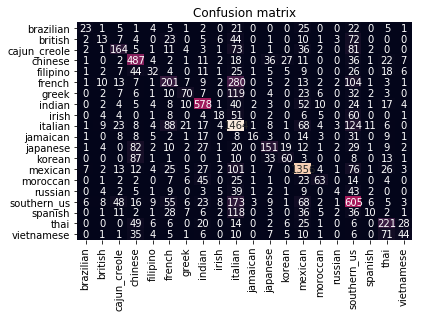

In [71]:
categories = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
             'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
             'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']
sns.heatmap(data=confusion_matrix(y_test, clf2.predict(X_test)), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

In [98]:
#Не мой код, но выглядит симпатично
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

[0.57, 0.2, 0.29]
[0.19, 0.07, 0.1]
[0.51, 0.43, 0.47]
[0.58, 0.71, 0.64]
[0.38, 0.18, 0.24]
[0.38, 0.28, 0.32]
[0.47, 0.23, 0.31]
[0.71, 0.77, 0.74]
[0.29, 0.09, 0.14]
[0.55, 0.79, 0.65]
[0.62, 0.16, 0.25]
[0.53, 0.41, 0.46]
[0.44, 0.27, 0.33]
[0.75, 0.82, 0.78]
[0.58, 0.31, 0.4]
[0.25, 0.03, 0.05]
[0.42, 0.58, 0.49]
[0.3, 0.05, 0.08]
[0.51, 0.58, 0.54]


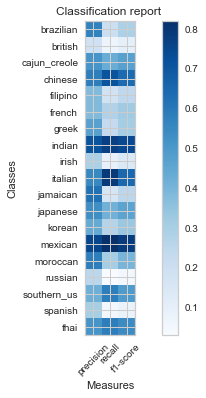

In [99]:
data = """             precision    recall  f1-score   support

   brazilian       0.57      0.20      0.29       116
     british       0.19      0.07      0.10       191
cajun_creole       0.51      0.43      0.47       388
     chinese       0.58      0.71      0.64       668
    filipino       0.38      0.18      0.24       197
      french       0.38      0.28      0.32       664
       greek       0.47      0.23      0.31       292
      indian       0.71      0.77      0.74       765
       irish       0.29      0.09      0.14       164
     italian       0.55      0.79      0.65      1865
    jamaican       0.62      0.16      0.25       127
    japanese       0.53      0.41      0.46       375
      korean       0.44      0.27      0.33       218
     mexican       0.75      0.82      0.78      1673
    moroccan       0.58      0.31      0.40       194
     russian       0.25      0.03      0.05       130
 southern_us       0.42      0.58      0.49      1055
     spanish       0.30      0.05      0.08       271
        thai       0.51      0.58      0.54       384
  vietnamese       0.43      0.22      0.29       207

 avg / total       0.54      0.56      0.53      9944"""


plot_classification_report(data)